# River Boundary Masking

## Introduction

Cold water refuges are crucial havens for fish species, offering them sanctuary and relief. These refuges are specific areas within aquatic ecosystems, such as deep pools or shaded sections, where the water remains relatively colder than the surrounding environment. With the increasing impact of climate change and its associated rising temperatures, cold water refuges serve as essential habitats for fish, providing them with a reprieve from stressful conditions and enabling their survival and reproductive success. By seeking out these refuges, fish can maintain optimal physiological functioning, evade thermal stress, and ensure the long-term sustainability of their populations.

In this section, we will use our realigned dataset to create river masks for our IR images. These masks will then be used to identify cold water refuges in the river in the next section. The segmentation model selected for use is Meta's SAM. The workflow overview of how it is utilized to create river masks is as follows:

* Create a ground truth dataset by hand using paint.net
* Create mechanism for creating point prompts for SAM
* Evaluate base model performance and generate masks

## Dataset

The first step is to build our ground truth dataset. It seems that the original processing done in 2012 included some preliminary river masks. Unfortunately, these masks are fairly poor. They also do not help with the construction of our ground truth dataset; it is easier to just manually create new masks than it is to patch up the existing masks.

The process of creating ground truth masks involves using the magic wand tool in paint.net, which selects an contiguous area of similar color based on some tolerance value. Then this area is filled with black and the rest of the image with white, and the mask can then be manually adjusted to match the river in areas where the magic wand fails to align perfectly with the river edge. 

The optimal results are achieved by using RGB images layered with transparency over the IR images, as the IR images have the highest contrast between river and non-river pixels. This is because reflectance of water is lower than soil and vegetation across a wide range of the electromagnetic spectrum, including within the visible RGB portion, but the difference is most significant in the IR range.

![Quadrant Filtering](../img/reflectance.png)

The difference in reflectance then results in the contrast between the river and land pixels being larger in the IR images. This also means that while both the RGB and IR remote sensing imagery may prove relevant to the model, the IR images will be the key to accurate segmentation. 

In [1]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from typing import Any
from util import SupervisedDataset, UnsupervisedDataset, TLDataset

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from PIL import Image as im
from IPython.display import display

# Finding central points
from skimage.morphology import erosion

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

Now that we have our ground truth masks, we need a PyTorch datastructure through which we can use them. We use an extended version of the VisionDataset class, creating our own SegmentationDataset class which has support for transforms. This will come in handy later when we do dataset augmentation.

The custom dataset class is used as follows.

In [3]:
ir_folder = "data/img/"
ir_prefix = "airborne_ir_"

rgb_folder = "out/realignment/"
rgb_prefix = "rgb_"

truth_folder = "truth/"
truth_prefix = "truth_"

all_data = UnsupervisedDataset("../", ir_folder, rgb_folder, ir_prefix, rgb_prefix)
data = SupervisedDataset(
    "../", ir_folder, rgb_folder, truth_folder, ir_prefix, rgb_prefix, truth_prefix, 
    transforms=None, seed=1, fraction=0.3, subset="Train",
)

# loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=12)

Found and loaded 306 images with glob rgb_*.png.
Found and loaded 10 images with glob truth_*.png.
Subset of 7 ground truth segmentation masks marked for Train.


In [4]:
datapoint_slider = widgets.IntSlider(
  value=0, min=0, max=len(data) - 1, step=1,
  description="Datapoint:"
)

def updateDatapoint(interpolation):
  index = int(interpolation)
  datapoint = data[index]
  figure, (rgb_ax, ir_ax, truth_ax) = plt.subplots(nrows=1, ncols=3, figsize=(10,10))

  rgb_ax.imshow(datapoint["ir"], cmap="hot")
  ir_ax.imshow(datapoint["rgb"])
  truth_ax.imshow(datapoint["mask"], cmap="gray")

# sample_idx = torch.randint(len(data), size=(1,)).item()
# datapoint = data[sample_idx] # type: ignore

data_preview = widgets.interactive(updateDatapoint, interpolation=datapoint_slider)
display(data_preview)

interactive(children=(IntSlider(value=0, description='Datapoint:', max=6), Output()), _dom_classes=('widget-in…

Set the `datapoint` variable to the data point selected above.

In [5]:
datapoint = data[datapoint_slider.value]
rgb_image = datapoint["rgb"]
ir_image = datapoint["ir"]

In [6]:
def createRoughMaskFromIR(image, threshold):
  _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
  return cv2.bitwise_not(binary_image)

def createRoughMaskFromHSVBounds(image, lower_blue, upper_blue):
  """
  Creates a binary mask from the provided image where any blue pixels in the
  original image are set to black in the mask, and all other pixels are white in the mask.

  ARGS:
    image (Mat): A cv2 image in RGB format.
    lower_blue (list[int]): A list of 3 integer numbers denoting in HSV colorspace the lower
    bound for what is considered blue. Note that hue should range from 0-179, while saturation
    and value should range from 0-255, as per cv2's implementation.
    upper_blue (list[int]): A list of 3 integer numbers denoting in HSV colorspace the upper
    bound for what is considered blue.
  """
  # Convert image to HSV color space
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define lower and upper bounds for blue color in HSV
  lower_blue = np.array(lower_blue, dtype=np.uint8)
  upper_blue = np.array(upper_blue, dtype=np.uint8)

  # Create a mask for blue pixels within the HSV bounds
  blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

  blank = np.ones_like(image, dtype=np.uint8) * 255 # create a blank white image of the same size as the original image
  result = cv2.bitwise_and(blank, blank, mask=blue_mask) # set blue pixels in the white image to black
  result = cv2.bitwise_not(result)
  
  return cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

def findMaskIntersection(mask1, mask2):
  # Ensure the masks have the same dimensions
  if mask1.shape != mask2.shape:
      raise ValueError("Mask images must have the same dimensions.")

  # Invert the masks
  inverted_mask1 = cv2.bitwise_not(mask1)
  inverted_mask2 = cv2.bitwise_not(mask2)

  # Compute the intersection of the inverted masks
  intersection = cv2.bitwise_not(cv2.bitwise_and(inverted_mask1, inverted_mask2))

  return intersection

def createRoughRiverMask(rgb_image, ir_image, low_blue, high_blue, max_temp, return_components = False):
  mask1 = createRoughMaskFromHSVBounds(rgb_image, low_blue, high_blue)
  mask2 = createRoughMaskFromIR(ir_image, max_temp)
  
  if return_components: return cv2.bitwise_and(mask1, mask2), mask1, mask2
  return cv2.bitwise_and(mask1, mask2)

In [7]:
hue_slider = widgets.IntRangeSlider(
  value=[0, 160],
  # value=[75, 140],
  min=0, max=179, step=1,
  description="Hue:",
)
sat_slider = widgets.IntRangeSlider(
  value=[10, 200],
  min=0, max=255, step=1,
  description="Saturation:",
)
val_slider = widgets.IntRangeSlider(
  value=[20, 230],
  min=0, max=255, step=1,
  description="Value:",
)
temp_slider = widgets.IntSlider(
  value=25,
  min=0, max=50, step=1,
  description="Max Temperature:",
)

def updateRoughMasks(hue_range, sat_range, val_range, max_temp):
  low_blue = [hue_range[0], sat_range[0], val_range[0]]
  high_blue = [hue_range[1], sat_range[1], val_range[1]]

  hsv_mask = createRoughMaskFromHSVBounds(rgb_image, low_blue, high_blue)
  temp_mask = createRoughMaskFromIR(ir_image, max_temp)
  result_mask = cv2.bitwise_and(hsv_mask, temp_mask)

  masks = [hsv_mask, temp_mask, result_mask]
  figure, axes = plt.subplots(nrows=1, ncols=len(masks))

  for idx, mask in enumerate(masks):
    axes[idx].imshow(mask)
    axes[idx].axis("off")

  plt.show()

interactive_plot = widgets.interactive(
  updateRoughMasks, 
  hue_range=hue_slider,
  sat_range=sat_slider,
  val_range=val_slider,
  max_temp=temp_slider,
)
display(interactive_plot)

interactive(children=(IntRangeSlider(value=(0, 160), description='Hue:', max=179), IntRangeSlider(value=(10, 2…

Creating mask via HSV thresholding...
Bounds: [0, 10, 20] [160, 200, 230]


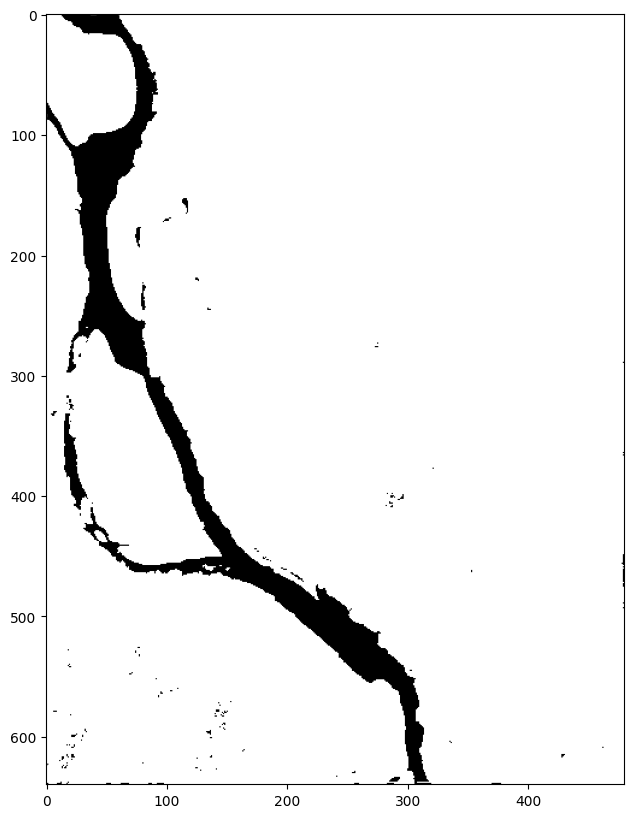

In [8]:
def getRoughRiverMask(datapoint, do_print = False, return_components = False):
  rgb_image = datapoint["rgb"]
  ir_image = datapoint["ir"]

  low_blue = [hue_slider.value[0], sat_slider.value[0], val_slider.value[0]] # [75, 10, 20]
  high_blue = [hue_slider.value[1], sat_slider.value[1], val_slider.value[1]] # [140, 200, 230]

  if do_print: print("Creating mask via HSV thresholding...\nBounds:", low_blue, high_blue)
  return createRoughRiverMask(rgb_image, ir_image, low_blue, high_blue, temp_slider.value, return_components)

mask: Any = getRoughRiverMask(datapoint, do_print=True)
plt.figure(figsize=(10,10))
plt.imshow(cv2.bitwise_not(mask), cmap="gray")
plt.axis("on")
plt.show()

In [9]:
"""
Adapted from Facebook's SAM predictor 
example workflow notebook.
"""

def show_mask(mask, ax, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
  if len(coords) == 0 or len(labels) == 0: return
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="P", s=marker_size, edgecolor="white", linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="X", s=marker_size, edgecolor="white", linewidth=1.25)   
    
def show_box(box, ax):
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0,0,0,0), lw=2)) # type: ignore

In [10]:
def controlPointsFromMask(mask, number, distance=0, positive=False, existing_points=[]):
  input_points = []

  def euclideanDistance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

  while len(input_points) < number:
    zero_indices = np.argwhere(mask != 0) if positive else np.argwhere(mask == 0)

    if len(zero_indices) > 0:

      found_valid = False
      while not found_valid:
        random_index = np.random.randint(0, len(zero_indices))
        row, col = zero_indices[random_index]
        new_point = [col, row]
        
        # Check if the new point is far enough from existing points
        too_close = False
        all_points = input_points + existing_points

        for point in all_points:
          if euclideanDistance(point, new_point) < distance:
            too_close = True
            break

        if not too_close:
          input_points.append(new_point)
          found_valid = True
          break
        else:
          zero_indices = np.delete(zero_indices, random_index, axis=0)
          if len(zero_indices) == 0:
            break
      # end while

      if not found_valid: # There are points left but none with enough distance between them.
        break
    
    else:
      break  # We have fewer than "number" points, but there are no valid points left.

  return np.array(input_points)

def generateInputPointsFromMask(
  number = None, 
  mask = None, 
  minDistance = 0,
  negativeSrcMask = None,
  numNegative = None,
  positiveSrcMask = None,
  numPositive = None,
):
  input_points = []
  input_labels = []

  _numPositive = numPositive if numPositive is not None else number
  if _numPositive is not None:
    control_points = controlPointsFromMask(
      positiveSrcMask if positiveSrcMask is not None else mask,
      _numPositive,
      distance=minDistance,
      positive=True
    )
    input_points.extend(control_points)
    input_labels.extend([1] * len(control_points))

  _numNegative = numNegative if numNegative is not None else number
  if _numNegative is not None:
    control_points = controlPointsFromMask(
      negativeSrcMask if negativeSrcMask is not None else mask,
      _numNegative,
      distance=minDistance,
      existing_points=input_points
    )
    input_points.extend(control_points)
    input_labels.extend([0] * len(control_points))

  input_points = np.array(input_points)
  input_labels = np.array(input_labels)

  return input_points, input_labels

square = np.array([
  [1,1,1],
  [1,1,1],
  [1,1,1],
])

def multiErode(im, num, element=square):
  for i in range(num):
    im = erosion(im, element)
  return im

In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

# TODO: fetch model if it isn't downloaded
sam_checkpoint = "../data/model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"
device = None

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

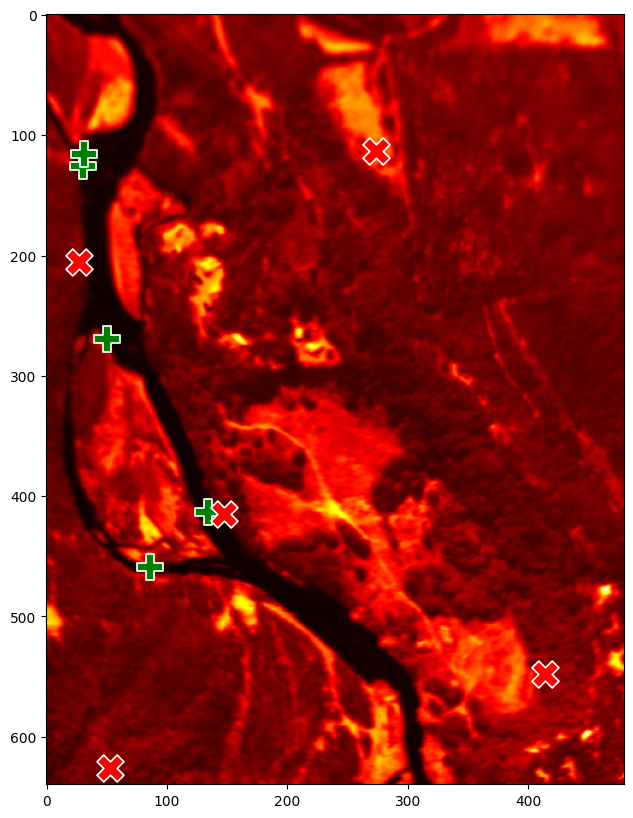

In [12]:
image = datapoint["predict"]

mask = getRoughRiverMask(datapoint)
input_points, input_labels = generateInputPointsFromMask(number=5, mask=mask)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_points, input_labels, plt.gca())
plt.show()

In [13]:
erode_slider = widgets.IntSlider(
  value=5,
  min=0, max=15, step=1,
  description="Erosion Factor:",
)
distance_slider = widgets.IntSlider(
  value=50,
  min=0, max=100, step=5,
  description="Min Distance:",
)
points_slider = widgets.IntSlider(
  value=5,
  min=2, max=15, step=1,
  description="Control Points:",
)

def getControlPoints(
  num_points = points_slider.value, 
  erosion_factor = erode_slider.value, 
  min_distance = distance_slider.value, 
  give_erosion_mask = False
  # include_negative_points TODO: implement this?
):
  mask = getRoughRiverMask(datapoint)
  binarized = mask > 1 # type: ignore
  eroded = multiErode(binarized, erosion_factor).astype(int)

  # result = generateInputPointsFromMask(numPositive=num_points, positiveSrcMask=eroded, minDistance=min_distance)
  result = generateInputPointsFromMask(number=num_points, mask=eroded, minDistance=min_distance)

  if give_erosion_mask:
    return eroded, result
  return result

def updateControlPoints(erosion_factor, num_points, min_distance, force_refresh):
  eroded, (input_points, input_labels) = getControlPoints(num_points, erosion_factor, min_distance, give_erosion_mask=True)
  figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

  axes[0].imshow(eroded)
  axes[1].imshow(image)
  show_points(input_points, input_labels, axes[1])

  plt.show()

randomize_button = widgets.ToggleButton(
  value=False,
  description="Generate",
  disabled=False,
)

interactive_plot = widgets.interactive(
  updateControlPoints, 
  erosion_factor=erode_slider,
  num_points=points_slider,
  min_distance=distance_slider,
  force_refresh=randomize_button,
)
display(interactive_plot)

interactive(children=(IntSlider(value=5, description='Erosion Factor:', max=15), IntSlider(value=5, descriptio…

Facebook's SAM provides 3 model sizes. For our purposes the smallest of the three, ViT-B, will suffice. The model checkpoint can be downloaded from [this](https://github.com/facebookresearch/segment-anything#model-checkpoints) link.

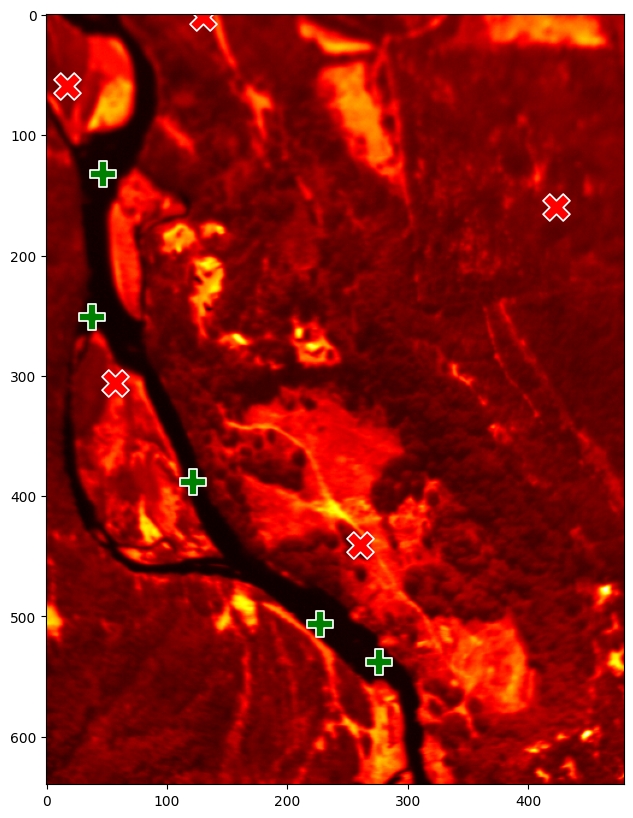

In [14]:
input_points, input_labels = getControlPoints()

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_points, input_labels, plt.gca())
plt.show()

In [15]:
predictor.set_image(image)

In [16]:
masks, scores, logits = predictor.predict(
  point_coords=input_points,
  point_labels=input_labels,
  multimask_output=False,
)

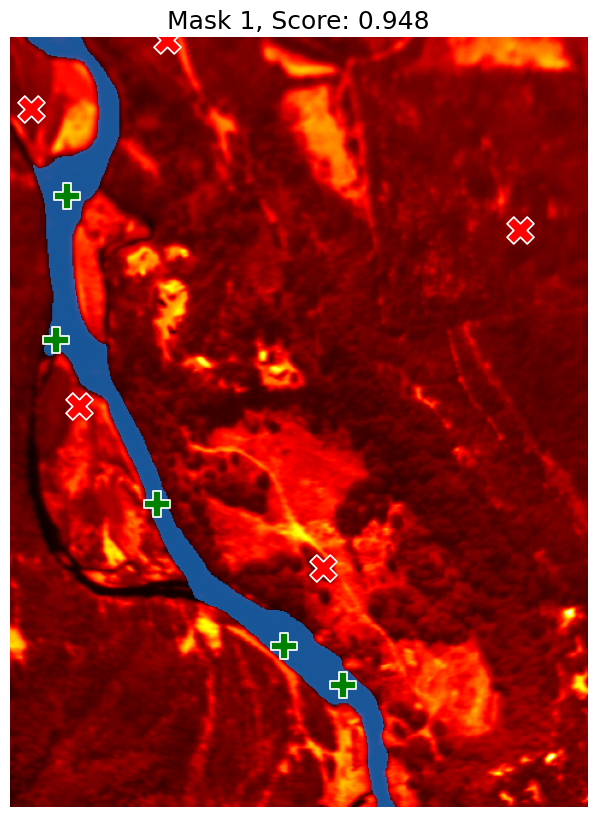

In [17]:
for i, (mask, score) in enumerate(zip(masks, scores)):
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  show_mask(mask, plt.gca())
  show_points(input_points, input_labels, plt.gca())
  plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
  plt.axis("off")
  plt.show()  

In [18]:
def multiPlot(
    images, 
    title: str = None, # type: ignore
    subtitles: list[str] = None, # type: ignore 
    cmaps: list[str] = None, # type: ignore
    figsize: tuple[int,int] = (10,5),
  ):
  figure, axes = plt.subplots(nrows=1, ncols=len(images), figsize=figsize)

  if title is not None:
    figure.suptitle(title)

  for idx, image in enumerate(images):
    axes[idx].imshow(image, cmap=cmaps[idx])
    axes[idx].axis("off")
    axes[idx].title.set_text(subtitles[idx])

  return figure, axes

In [19]:
def visualizeMaskAccuracy(datapoint, prediction, control_points = None, best_values = None, has_ground_truth = True):
  best_input_points = best_input_labels = best_index = best_score = all_scores = best_erosion = None
  if control_points is not None: best_input_points, best_input_labels = control_points
  if best_values is not None: best_index, best_score, all_scores, best_erosion = best_values
  
  prediction = np.where(prediction, 255, 0)
  truth: Any = None
  error: Any = None

  if has_ground_truth:
    truth = datapoint["display_mask"]
    error = cv2.bitwise_xor(prediction, truth)

  if has_ground_truth: 
    print("Misclasified pixels:", np.count_nonzero(error))
    print("Total river pixels:", np.count_nonzero(truth))
    # print(f"Error rate: {100 * round(np.count_nonzero(error) / np.count_nonzero(truth), 4)}%")
    print(f"Error rate: {100 * round(np.count_nonzero(error) / (prediction.shape[0] * prediction.shape[1]), 4)}%")

    # TODO: use mean Intersection over Union for evaluation score

  plot_images = [datapoint["rgb"], datapoint["ir"], prediction, truth, error] if has_ground_truth else [datapoint["rgb"], datapoint["ir"], prediction]
  plot_titles = ["RGB", "IR", "Prediction", "Truth", "Error"]
  plot_cmaps = [None, "hot", "gray", "gray", "gray"]
  
  figure, axes = multiPlot(plot_images, subtitles=plot_titles, cmaps=plot_cmaps, figsize=(15,15))
  
  if control_points is not None:
    show_mask(prediction, axes[0])
    show_points(best_input_points, best_input_labels, axes[0])

  if best_values is not None:
    plot_title = f"Mask {best_index} (Score: {best_score:.3f})"
    if best_erosion is not None: plot_title = f"Mask {best_index} (Erosion: {best_erosion}, Score: {best_score:.3f})"
    plt.title(plot_title, fontsize=18)
    
    print(f"Minimum Score: {np.min(all_scores)}") # type: ignore
    print(f"Median Score: {np.median(all_scores)}") # type: ignore
    print(f"Mean Score: {np.mean(all_scores)}") # type: ignore

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 4921
Total river pixels: 17676
Error rate: 1.6%


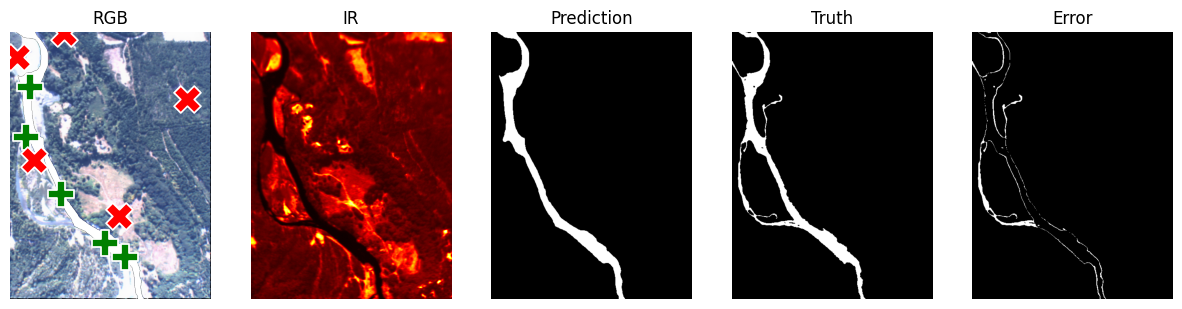

In [20]:
visualizeMaskAccuracy(datapoint, mask, (input_points, input_labels))

In [21]:
def bestOfMultiRoundPrediction(image, num_rounds: int, erosion_range: range = None):
  # print("Setting predictor image...", end="\r")
  predictor.set_image(image)

  all_scores = []

  best_index, best_mask, best_score, best_erosion = [0, None, 0, None]
  best_input_points, best_input_labels = [None, None]

  _erosion_range = erosion_range if erosion_range is not None else [None]

  for erosion_val in _erosion_range:
    for i in range(num_rounds):
      # print(f"Computing prediction round #{i} with erosion={erosion_val}", end="   \r")
      input_points, input_labels = getControlPoints(erosion_factor=erosion_val)

      if len(input_points) == 0: continue
      masks, scores, _logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        # multimask_output=True,
        multimask_output=False,
      )
      
      all_scores.append(scores[0])
      if (scores[0] > best_score):
        best_index = i
        best_score = scores[0]
        best_mask = masks[0]
        best_erosion = erosion_val

        best_input_points = input_points
        best_input_labels = input_labels

  return best_mask, (best_input_points, best_input_labels), (best_index, best_score, all_scores, best_erosion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Misclasified pixels: 4781
Total river pixels: 17676
Error rate: 1.5599999999999998%


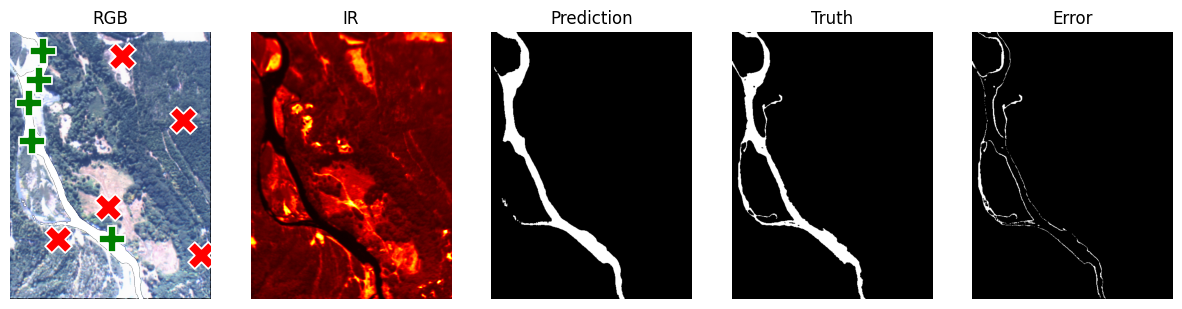

In [22]:
best_mask, control_points, best_values = bestOfMultiRoundPrediction(image, 15, range(0, 10, 1))
visualizeMaskAccuracy(datapoint, best_mask, control_points)

In [23]:
# for sample_idx in range(len(data)):
#   datapoint = data[sample_idx]
#   best_mask, control_points, best_values = bestOfMultiRoundPrediction(datapoint["predict"], 15, range(0, 10, 1))
#   visualizeMaskAccuracy(datapoint, best_mask, control_points, best_values, has_ground_truth=False)

# for sample_idx in range(50):
  # datapoint = all_data[sample_idx]
  # best_mask, control_points, best_values = bestOfMultiRoundPrediction(datapoint["predict"], 15, range(0, 10, 1))
  # visualizeMaskAccuracy(datapoint, best_mask, control_points, best_values, has_ground_truth=False)

NOTE TO SELF:\
ir_image_{x} matches with cropped_{x-1} and with truth_{x}<br>
ir images are degree in celsius

In [24]:
train_data = TLDataset(
    "../learning/", "imagery/", "masks/", "*_corrected.png", 
    seed=1, subset="Train", fraction=.1
)

Found and loaded 4382 images with glob *_corrected.png.
Subset of 3944 ground truth segmentation masks marked for Train.


In [25]:
datapoint_slider = widgets.IntSlider(
  value=1, min=0, max=len(train_data) - 1, step=1,
  description="Datapoint:"
)
prev_button = widgets.Button(
  description="Prev",
  tooltip="Prev",
  disabled=False,
  button_style="",
  icon="arrow-left"
)
next_button = widgets.Button(
  description="Next",
  tooltip="Next",
  disabled=False,
  button_style="",
  icon="arrow-right"
)

def changeSliderValue(diff):
  next_value = datapoint_slider.value + diff
  if next_value > datapoint_slider.min and next_value < datapoint_slider.max:
    datapoint_slider.value = next_value

def incrementSliderValue(_ignore): changeSliderValue(1)
def decrementSliderValue(_ignore): changeSliderValue(-1)

prev_button.on_click(decrementSliderValue)
next_button.on_click(incrementSliderValue)

erode_slider = widgets.IntSlider(
  value=7,
  min=0, max=15, step=1,
  description="Erosion Factor:",
)
distance_slider = widgets.IntSlider(
  value=50,
  min=0, max=100, step=5,
  description="Min Distance:",
)
points_slider = widgets.IntSlider(
  value=5,
  min=2, max=15, step=1,
  description="Control Points:",
)

def getControlPointsFromTruth(
  datapoint,
  num_points = points_slider.value, 
  erosion_factor = erode_slider.value, 
  min_distance = distance_slider.value, 
  give_erosion_mask = False,
  include_negative_points = False,
):
  mask = datapoint["mask"]
  binarized = mask > 0
  eroded = multiErode(binarized, erosion_factor).astype(int)

  result = None
  if include_negative_points:
    result = generateInputPointsFromMask(number=num_points, mask=eroded, minDistance=min_distance)
  else:
    result = generateInputPointsFromMask(numPositive=num_points, positiveSrcMask=eroded, minDistance=min_distance)

  if give_erosion_mask:
    return eroded, result
  return result

def updateControlPoints(datapoint_index, erosion_factor, num_points, min_distance, force_refresh):
  index = int(datapoint_index)
  datapoint = train_data[index]
  print(datapoint["name"])

  eroded, (input_points, input_labels) = getControlPointsFromTruth(datapoint, num_points, erosion_factor, min_distance, give_erosion_mask=True)
  
  plot_images = [datapoint["image"], datapoint["mask"], eroded, datapoint["image"]]
  plot_titles = ["Original", "Segmentation Truth", "Eroded", "Control Points"]
  plot_cmaps = [None, "gray", None, None]

  figure, axes = multiPlot(plot_images, subtitles=plot_titles, cmaps=plot_cmaps, figsize=(15,4))
  show_points(input_points, input_labels, axes[3])

  plt.show()

randomize_button = widgets.ToggleButton(
  value=False,
  description="Generate",
  disabled=False,
)

buttons_layout = widgets.HBox([prev_button, next_button])
interactive_plot = widgets.interactive(
  updateControlPoints,
  datapoint_index=datapoint_slider,
  erosion_factor=erode_slider,
  num_points=points_slider,
  min_distance=distance_slider,
  force_refresh=randomize_button,
)
display(buttons_layout, interactive_plot)

interactive(children=(IntSlider(value=1, description='Datapoint:', max=3943), IntSlider(value=7, description='…

In [44]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    datapoint = self.dataset[idx]

    # Get control points prompt.
    input_points, input_labels = getControlPointsFromTruth(datapoint)
    input_points = input_points.astype(float).tolist()
    input_labels = input_labels.tolist()
    input_labels = [[x] for x in input_labels]

    # Prepare the image and prompt for the model.
    inputs = self.processor(datapoint["image"], input_points=input_points, input_labels=input_labels, return_tensors="pt")

    # Remove batch dimension which the processor adds by default.
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    inputs["input_points"] = inputs["input_points"].squeeze(1)
    inputs["input_labels"] = inputs["input_labels"].squeeze(1)

    # Add ground truth segmentation mask.
    inputs["ground_truth_mask"] = datapoint["mask"]
    return inputs

In [45]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_dataset = SAMDataset(dataset=train_data, processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [46]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([5, 2])
input_labels torch.Size([5, 1])
ground_truth_mask (1024, 1024)


In [33]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_points torch.Size([2, 5, 2])
input_labels torch.Size([2, 5, 1])
ground_truth_mask torch.Size([2, 1024, 1024])


In [34]:
from transformers import SamModel, PreTrainedModel

model: PreTrainedModel = SamModel.from_pretrained("facebook/sam-vit-base") # type: ignore
# model = SamModel.from_pretrained("facebook/sam-vit-huge")

# Ensure we only compute gradients for mask decoder.
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [35]:
def diceLoss(pred,target):
  numerator = 2 * torch.sum(pred * target)
  denominator = torch.sum(pred + target)
  return 1 - (numerator + 1) / (denominator + 1)

In [36]:
from torch.optim import Adam

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

In [37]:
from tqdm import tqdm
from statistics import mean

num_epochs = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

for epoch in range(num_epochs):
  epoch_losses = []
  
  for batch in tqdm(train_dataloader):
    # Forward Pass

    for k,v in batch.items():
      print(k,v.shape)
      
    outputs = model(
      pixel_values=batch["pixel_values"].to(device),
      input_points=batch["input_points"].to(device),
      input_labels=batch["input_labels"].to(device),
      multimask_output=False,
    ) # type: ignore

    # Compute Loss
    predicted_masks = outputs.pred_masks.squeeze(1)
    ground_truth_masks = batch["ground_truth_mask"].float().to(device)
    loss = diceLoss(predicted_masks, ground_truth_masks.unsqueeze(1))

    # Backward Pass (compute gradients of parameters w.r.t. loss)
    optimizer.zero_grad()
    loss.backward()

    # Optimize Step
    optimizer.step()
    epoch_losses.append(loss.item())

  print(f"EPOCH: {epoch}")
  print(f"Mean loss: {mean(epoch_losses)}")

  0%|          | 0/1972 [00:00<?, ?it/s]

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_points torch.Size([2, 5, 2])
input_labels torch.Size([2, 5, 1])
ground_truth_mask torch.Size([2, 1024, 1024])


ValueError: ('The input_points must be a 4D tensor. Of shape `batch_size`, `point_batch_size`, `nb_points_per_image`, `2`.', ' got torch.Size([2, 5, 2]).')

In [ ]:
from datasets import load_dataset

dataset = load_dataset("stodoran/elwha-segmentation-large", split="validation")

Generating train split:   0%|          | 0/3944 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/438 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 438
})

In [ ]:
def displayMask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def overlayMask(index):
    fig, axes = plt.subplots()
    datapoint = dataset[index] # type: ignore

    axes.imshow(np.array(datapoint["image"]))
    ground_truth_seg = np.array(datapoint["label"])
    displayMask(ground_truth_seg, axes)
    axes.axis("off")

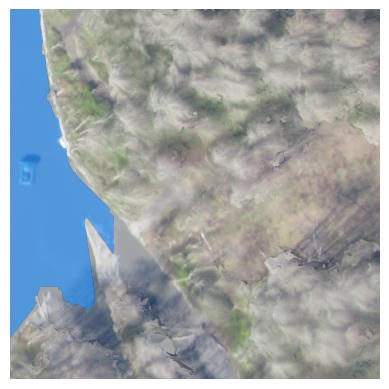

In [ ]:
overlayMask(0)

In [ ]:
# TODO: continue following NielsRogge/Transformers-Tutorials, next step is to create SAMDataset
# TODO: go through the entire dataset, and mark all images which are faulty
# TODO: either throw out or correct faulty images, then upload to huggingface with notebook